## RFM Customer Segmentation using Unsupervised Learning

**RFM Customer Segmentation using Unsupervised Learning**

We’ll perform an end-to-end clustering pipeline:

1. Explore and understand the RFM data
2. Test scaling suitability and visualize distributions
3. Apply and tune K-Means, Hierarchical, and DBSCAN
4. Find optimal cluster numbers
5. Profile clusters and interpret results
6. Map to business-relevant segments

### 1. Import Essential Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Display setup
sns.set(style='whitegrid', palette='muted', font_scale=1.1)

### 2. Loading the Data and Inspection

#### Data Loading

In [2]:
# Load RFM table
rfm = pd.read_csv("../data/rfm_table.csv")

#### Data Inspection

In [3]:
rfm.head()

,CustomerID,recency_days,frequency,monetary
0,C1010011,26,1,4750.0
1,C1010012,69,1,1499.0
2,C1010014,76,2,1455.0
3,C1010018,37,1,30.0
4,C1010024,65,1,5000.0


In [4]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 788698 entries, 0 to 788697
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   CustomerID    788698 non-null  object 
 1   recency_days  788698 non-null  int64  
 2   frequency     788698 non-null  int64  
 3   monetary      788698 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 24.1+ MB


In [5]:
rfm.describe(include="all")

,CustomerID,recency_days,frequency,monetary
count,788698,788698.000000,788698.000000,7.886980e+05
unique,788698,NaN,NaN,NaN
top,C1010011,NaN,NaN,NaN
freq,1,NaN,NaN,NaN
mean,NaN,56.304733,1.161457,1.888014e+03
std,NaN,15.310665,0.418052,7.329482e+03
min,NaN,1.000000,1.000000,0.000000e+00
25%,NaN,44.000000,1.000000,2.000000e+02
50%,NaN,56.000000,1.000000,5.590000e+02
75%,NaN,69.000000,1.000000,1.519517e+03


#### Checking Missing Values

In [6]:
print("Missing Values:\n", rfm.isna().sum())

Missing Values:
 CustomerID      0
recency_days    0
frequency       0
monetary        0
dtype: int64


In [7]:
print(rfm.columns)

Index(['CustomerID', 'recency_days', 'frequency', 'monetary'], dtype='object')


#### Viewing Relationships

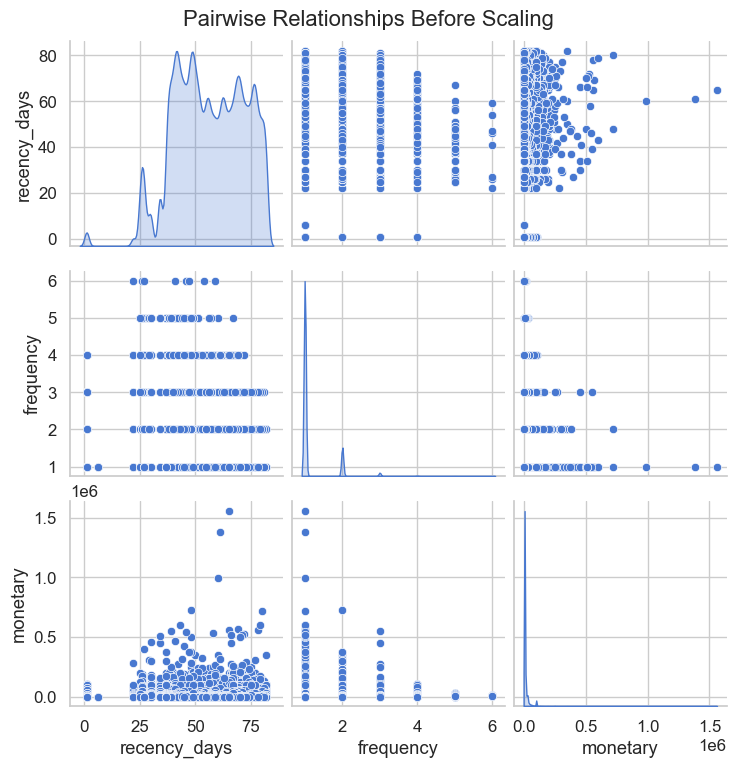

In [8]:
sns.pairplot(rfm[['recency_days', 'frequency', 'monetary']], diag_kind='kde')
plt.suptitle("Pairwise Relationships Before Scaling", y=1.02)
plt.show()

#### Visualizing the distribution before Scaling
Before scaling, we inspect how much the features vary. StandardScaler is best when features have Gaussian-like distributions, while MinMaxScaler is better for skewed data.

recency_days    -0.253586
frequency        2.765079
monetary        44.428735
dtype: float64


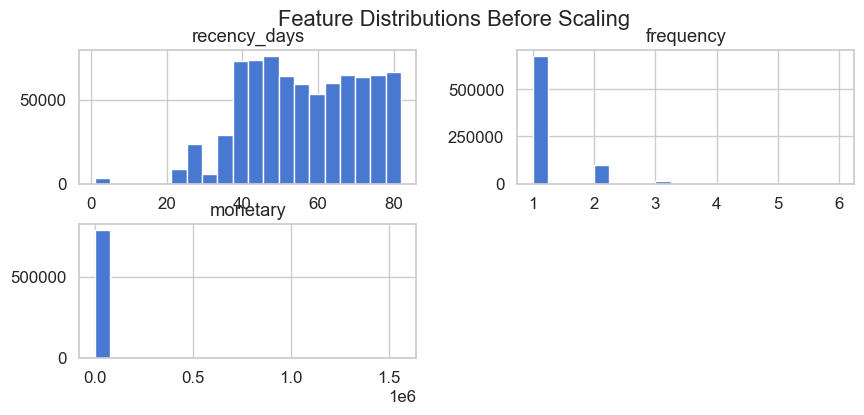

In [9]:
# Visualize skewness
print(rfm[['recency_days', 'frequency', 'monetary']].skew())

# Compare histograms before scaling
rfm[['recency_days', 'frequency', 'monetary']].hist(bins=20, figsize=(10, 4))
plt.suptitle("Feature Distributions Before Scaling")
plt.show()

#### Applying Log Transform to only Frequency and Monetary

In [10]:
# Make modeling copy
rfm_model = rfm.copy()

# Keep recency as is
rfm_model['R'] = rfm_model['recency_days']

# Log-transform highly skewed features
rfm_model['F_log'] = np.log1p(rfm_model['frequency'])
rfm_model['M_log'] = np.log1p(rfm_model['monetary'])

# Check skewness after transform
print(rfm_model[['R', 'F_log', 'M_log']].skew())


R       -0.253586
F_log    2.374403
M_log   -0.182056
dtype: float64


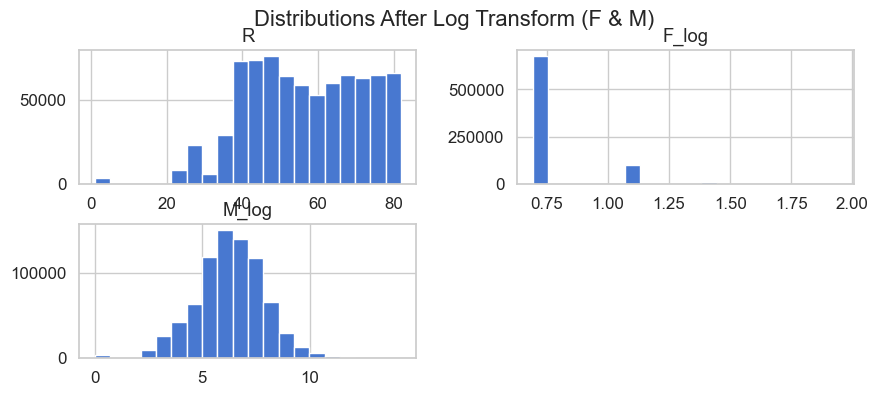

In [11]:
rfm_model[['R', 'F_log', 'M_log']].hist(bins=20, figsize=(10,4))
plt.suptitle("Distributions After Log Transform (F & M)")
plt.show()

#### Scaling and Visualizing after Scaling

In [15]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Ensure we are using the transformed columns
X = rfm_model[['R', 'F_log', 'M_log']].copy()

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Optional: inspect scaled values as dataframe
X_scaled_df = pd.DataFrame(X_scaled, columns=['R_scaled','F_log_scaled','M_log_scaled'])

print("✅ Scaling complete. Summary of scaled features:")
print(X_scaled_df.describe().round(3))


✅ Scaling complete. Summary of scaled features:
         R_scaled  F_log_scaled  M_log_scaled
count  788698.000    788698.000    788698.000
mean        0.000        -0.000        -0.000
std         1.000         1.000         1.000
min        -3.612        -0.397        -3.991
25%        -0.804        -0.397        -0.629
50%        -0.020        -0.397         0.021
75%         0.829        -0.397         0.654
max         1.678         7.473         5.049


#### 5. Finding Optimal K

##### We’ll use three methods:
1.Elbow Method
2. Silhouette Score

In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np

K_range = range(2, 11)
inertias, sils, dbs, chs = [], [], [], []

print(f"{'K':>3} | {'Inertia':>12} | {'Silhouette':>12} | {'Davies-B':>10} | {'Calinski-H':>12}")
print("-"*65)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=20, max_iter=500)
    labels = km.fit_predict(X_scaled)

    # Sample silhouette to avoid memory issues
    sample_size = min(10000, len(X_scaled))
    idx_sample = np.random.choice(len(X_scaled), sample_size, replace=False)
    sil = silhouette_score(X_scaled[idx_sample], labels[idx_sample])

    db = davies_bouldin_score(X_scaled, labels)
    ch = calinski_harabasz_score(X_scaled, labels)

    inertias.append(km.inertia_)
    sils.append(sil)
    dbs.append(db)
    chs.append(ch)

    print(f"{k:>3} | {km.inertia_:>12.0f} | {sil:>12.4f} | {db:>10.4f} | {ch:>12.0f}")


  K |      Inertia |   Silhouette |   Davies-B |   Calinski-H
-----------------------------------------------------------------
  2 |      1532379 |       0.4929 |     0.8259 |       429103
  3 |      1049049 |       0.3824 |     1.0006 |       495091
  4 |       778917 |       0.3812 |     0.8640 |       535706
  5 |       643380 |       0.3584 |     0.8646 |       527955
  6 |       570636 |       0.3475 |     0.8929 |       496314
  7 |       515711 |       0.3241 |     1.0479 |       471644
  8 |       462607 |       0.3214 |     0.9921 |       463611
  9 |       416195 |       0.3285 |     0.9593 |       461883
 10 |       376084 |       0.3311 |     0.9068 |       463700


#### Plotting the K

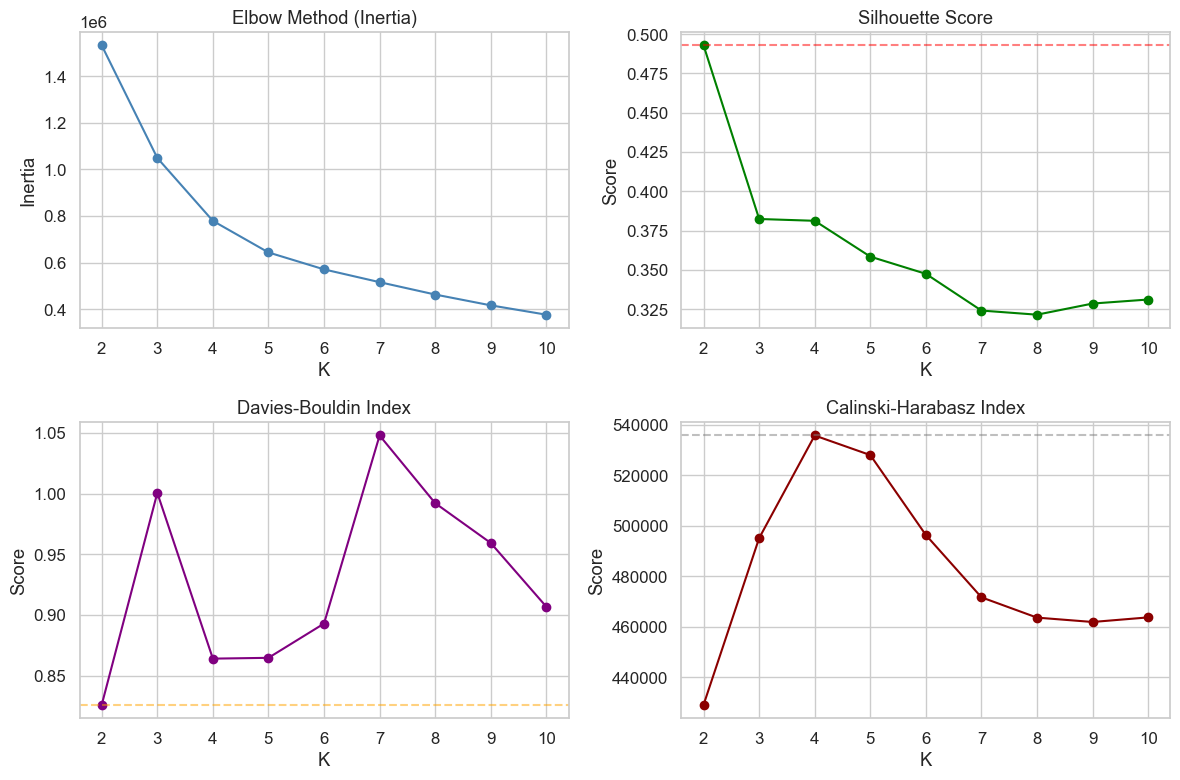

In [17]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# --- 1) Elbow (Inertia: lower is better)
axes[0,0].plot(K_range, inertias, 'o-', color='steelblue')
axes[0,0].set_title("Elbow Method (Inertia)")
axes[0,0].set_xlabel("K")
axes[0,0].set_ylabel("Inertia")

# --- 2) Silhouette (higher is better)
axes[0,1].plot(K_range, sils, 'o-', color='green')
axes[0,1].axhline(max(sils), ls='--', color='red', alpha=0.5)
axes[0,1].set_title("Silhouette Score")
axes[0,1].set_xlabel("K")
axes[0,1].set_ylabel("Score")

# --- 3) Davies-Bouldin (lower is better)
axes[1,0].plot(K_range, dbs, 'o-', color='purple')
axes[1,0].axhline(min(dbs), ls='--', color='orange', alpha=0.5)
axes[1,0].set_title("Davies-Bouldin Index")
axes[1,0].set_xlabel("K")
axes[1,0].set_ylabel("Score")

# --- 4) Calinski-Harabasz (higher is better)
axes[1,1].plot(K_range, chs, 'o-', color='darkred')
axes[1,1].axhline(max(chs), ls='--', color='gray', alpha=0.5)
axes[1,1].set_title("Calinski-Harabasz Index")
axes[1,1].set_xlabel("K")
axes[1,1].set_ylabel("Score")

plt.tight_layout()
plt.show()


## 📌 Model Selection — Interpreting Clustering Evaluation Metrics

We evaluated K-Means for **K = 2 to 10** using four metrics:

| Metric | Goal | Interpretation |
|--------|------|----------------|
| **Inertia (WCSS)** | Lower is better | Measures compactness of clusters |
| **Silhouette Score** | Higher is better | Measures how well-separated clusters are |
| **Davies-Bouldin Index** | Lower is better | Measures average similarity between clusters |
| **Calinski-Harabasz Index** | Higher is better | Balance between compactness and separation |

---

### 🔍 Observations from the Plots

#### **1) Elbow Method (Inertia)**
- Rapid decrease up to **K = 4**
- After K = 4, reduction slows (diminishing returns)
- ✅ Suggests **K ≈ 4**

#### **2) Silhouette Score**
- Maximum at **K = 2**
- Clear drop at **K = 3–4**, then stabilizes
- ✅ Suggests **K = 2–3** but still acceptable at **K = 4**

#### **3) Davies-Bouldin Index**
- Lower values at **K = 2 and K = 4**
- Higher values (worse) around **K = 7**
- ✅ Suggests **K = 2 or K = 4**

#### **4) Calinski-Harabasz Index**
- Peak around **K = 4**
- Values decrease afterward
- ✅ Strongly supports **K = 4**

---

### ✅ Final Conclusion — Optimal K

Although Silhouette is highest at K = 2, other metrics (Inertia, DB, CH) clearly indicate that:

> **K = 4 provides the best overall balance between compactness and separation.**  
> It is also more meaningful for business segmentation than K = 2.

**✅ Recommended number of clusters: `K = 4`**


#### ✅ Final K-Means Clustering using Optimal K = 4
####    Attach cluster labels to RFM table and evaluate quality
#### ============================================================

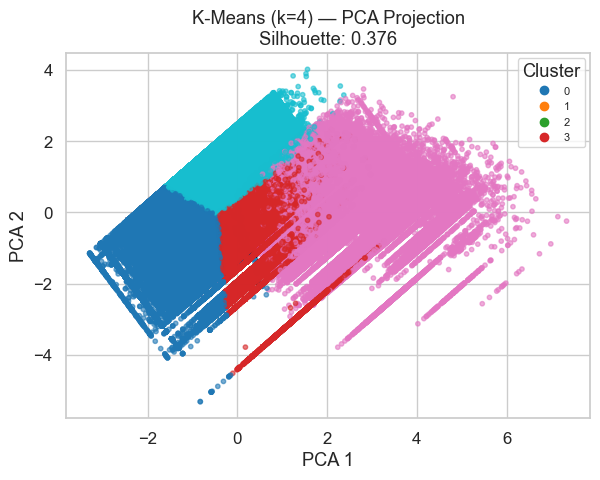

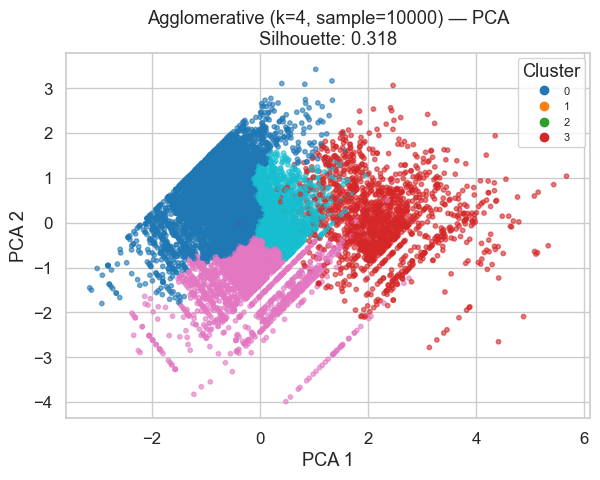

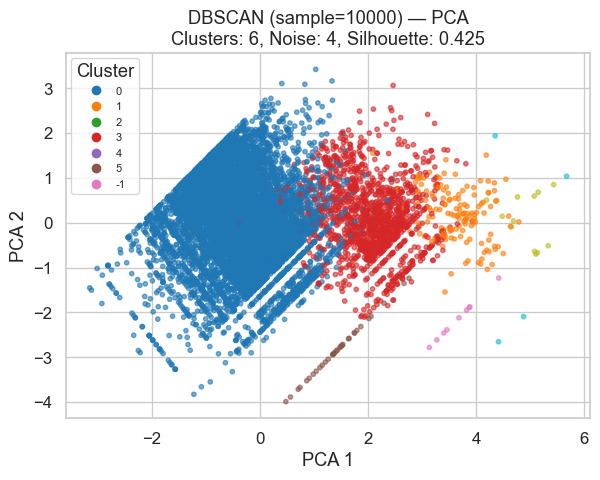

,Method,Clusters,Noise (if any),Silhouette,Notes
0,KMeans (full),4,0,0.3761,"k=4, n=788698"
1,Agglomerative (sample),4,0,0.3184,"n=10000, linkage=ward"
2,DBSCAN (sample),6,4,0.4252,"n=10000, eps=1.2, min_samples=5"


In [14]:

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np

k_selected = 4

final_kmeans = KMeans(
    n_clusters=k_selected,
    random_state=42,
    n_init=20,
    max_iter=500
)

labels = final_kmeans.fit_predict(X_scaled)   # <-- use scaled features
rfm['Cluster'] = labels                      # <-- attach to original RFM

print(f"✅ Created {k_selected} clusters")
print("\n📊 Cluster Distribution:")
print(rfm['Cluster'].value_counts().sort_index())

# ---- Evaluation Metrics ----
sample_size = min(10000, len(X_scaled))
idx = np.random.choice(len(X_scaled), sample_size, replace=False)

sil = silhouette_score(X_scaled[idx], labels[idx])  # sampled silhouette
db  = davies_bouldin_score(X_scaled, labels)
ch  = calinski_harabasz_score(X_scaled, labels)

print("\n📌 Quality Metrics for Final Clustering")
print(f"Silhouette Score     : {sil:.4f}  (higher = better)")
print(f"Davies-Bouldin Index : {db:.4f}  (lower = better)")
print(f"Calinski-Harabasz    : {ch:,.0f}  (higher = better)")


In [25]:
# --- remove any old column written by the K loop (optional safety) ---
if 'Cluster' in rfm.columns:
    rfm = rfm.drop(columns=['Cluster'])

# --- FINAL clustering ONLY (k = 4) ---
from sklearn.cluster import KMeans
k_selected = 4
final_kmeans = KMeans(n_clusters=k_selected, random_state=42, n_init=20, max_iter=500)
final_labels = final_kmeans.fit_predict(X_scaled)

# attach final labels to BOTH frames if you use both
rfm['Cluster'] = final_labels
rfm_model['Cluster'] = final_labels

# --- print distribution (should show 4 clusters: 0..3) ---
dist = rfm['Cluster'].value_counts().sort_index()
print("Cluster distribution:\n")
print(dist.to_frame('count'))


Cluster distribution:

          count
Cluster        
0        113116
1        244806
2        179081
3        251695


#### Build Segment Profile by Cluster

In [26]:
cluster_profiles = (
    rfm.groupby('Cluster')
    .agg(
        Customers=('CustomerID', 'count'),
        Recency_Mean=('recency_days', 'mean'),
        Frequency_Mean=('frequency', 'mean'),
        Monetary_Mean=('monetary', 'mean')
    )
    .round(2)
)

# Add percentage of total customers
cluster_profiles['Percentage'] = (cluster_profiles['Customers'] / len(rfm) * 100).round(1)

print("\n📊 Cluster profiles (key metrics):\n")
print(cluster_profiles[['Customers','Percentage','Recency_Mean','Frequency_Mean','Monetary_Mean']])



📊 Cluster profiles (key metrics):

         Customers  Percentage  Recency_Mean  Frequency_Mean  Monetary_Mean
Cluster                                                                    
0           113116        14.3         48.44            2.13        3444.23
1           244806        31.0         42.98            1.00        1995.47
2           179081        22.7         59.02            1.00         101.69
3           251695        31.9         70.87            1.00        2355.07


#### Segment Profiling

In [27]:
import numpy as np
import pandas as pd
from scipy.stats import percentileofscore

# ===========================================
# 1) Build base profiles (count, means, sums)
# ===========================================
profiles = (
    rfm.groupby('Cluster')
    .agg(
        Customers      = ('CustomerID', 'count'),
        Recency_Mean   = ('recency_days', 'mean'),
        Frequency_Mean = ('frequency', 'mean'),
        Monetary_Mean  = ('monetary', 'mean'),
        Revenue_Sum    = ('monetary', 'sum')
    )
    .round(2)
)

# % share of customers and revenue
profiles['Percentage'] = (profiles['Customers'] / len(rfm) * 100).round(1)
profiles['Revenue_%']  = (profiles['Revenue_Sum'] / profiles['Revenue_Sum'].sum() * 100).round(1)

# ===========================================
# 2) Global percentiles for interpretation
# ===========================================
rec_p = np.percentile(rfm['recency_days'], [30,50,70,90])
freq_p = np.percentile(rfm['frequency'], [60,80])
mon_p = np.percentile(rfm['monetary'], [70,90])

# percentile rank of cluster means vs global distribution
profiles['Recency_Pctl']   = profiles['Recency_Mean'].apply(lambda v: percentileofscore(rfm['recency_days'], v))
profiles['Frequency_Pctl'] = profiles['Frequency_Mean'].apply(lambda v: percentileofscore(rfm['frequency'], v))
profiles['Monetary_Pctl']  = profiles['Monetary_Mean'].apply(lambda v: percentileofscore(rfm['monetary'], v))

# ===========================================
# 3) Display final segment profile sorted by revenue
# ===========================================
cols = [
    'Customers','Percentage','Revenue_Sum','Revenue_%',
    'Recency_Mean','Recency_Pctl',
    'Frequency_Mean','Frequency_Pctl',
    'Monetary_Mean','Monetary_Pctl'
]

print("\n📊 Cluster Analysis (sorted by Revenue):\n")
print(profiles[cols].sort_values('Revenue_Sum',ascending=False))



📊 Cluster Analysis (sorted by Revenue):

         Customers  Percentage   Revenue_Sum  Revenue_%  Recency_Mean  \
Cluster                                                                 
3           251695        31.9  5.927605e+08       39.8         70.87   
1           244806        31.0  4.885033e+08       32.8         42.98   
0           113116        14.3  3.895979e+08       26.2         48.44   
2           179081        22.7  1.821112e+07        1.2         59.02   

         Recency_Pctl  Frequency_Mean  Frequency_Pctl  Monetary_Mean  \
Cluster                                                                
3           77.697420            1.00       42.824820        2355.07   
1           20.902044            1.00       42.824820        1995.47   
0           34.474159            2.13       98.365027        3444.23   
2           56.232297            1.00       42.824820         101.69   

         Monetary_Pctl  
Cluster                 
3            83.828791  
1          

#### Cluster Interpretation (Business Insight)

Using the RFM-based clustering (K = 4), we interpret the segments as follows:

| Cluster | Revenue Share | Behavioral Summary | Business Meaning |
|--------:|---------------|--------------------|------------------|
| **1** | **32.8%** | Recent purchases, high monetary value, low repeat frequency | **Active High-Value Customers (VIP)** |
| **0** | **26.2%** | Moderate recency, highest repeat frequency, strong spending | **Loyal Returning Buyers** |
| **3** | **39.8%** | Not recent, low frequency, but high monetary historically | **Big Spenders at Risk (Churn Risk)** |
| **2** | **1.2%** | Mid recency, low monetary, minimal repeat behavior | **Low-Value / One-Time Buyers** |

### Key Insights

- **Cluster 3** contributes the **highest revenue (≈40%)** but shows **high recency (lack of recent activity)** → They are at **risk of churn** and should be reactivated.
- **Cluster 1** are **valuable recent customers** who are actively purchasing and should be **nurtured with VIP retention strategies**.
- **Cluster 0** represents **stable loyal customers** with high repeat behavior — candidates for **loyalty programs and upsell**.
- **Cluster 2** contributes **negligible revenue** — represents low-engagement or new users. Marketing should be **low-cost & automated**.

### Business Action Recommendations

- **Re-engage Cluster 3 (Big Spenders at Risk)** with win-back incentives.
- **Reward Cluster 1 (VIPs)** with exclusive offers to maintain loyalty.
- **Upsell/Cross-sell Cluster 0 (Loyal Buyers)** to increase ARPU.
- **Automate nurture emails for Cluster 2** instead of spending budget.

---

This interpretation helps translate raw clusters into clear **customer segments with business meaning and actionable strategy.**


## EDA

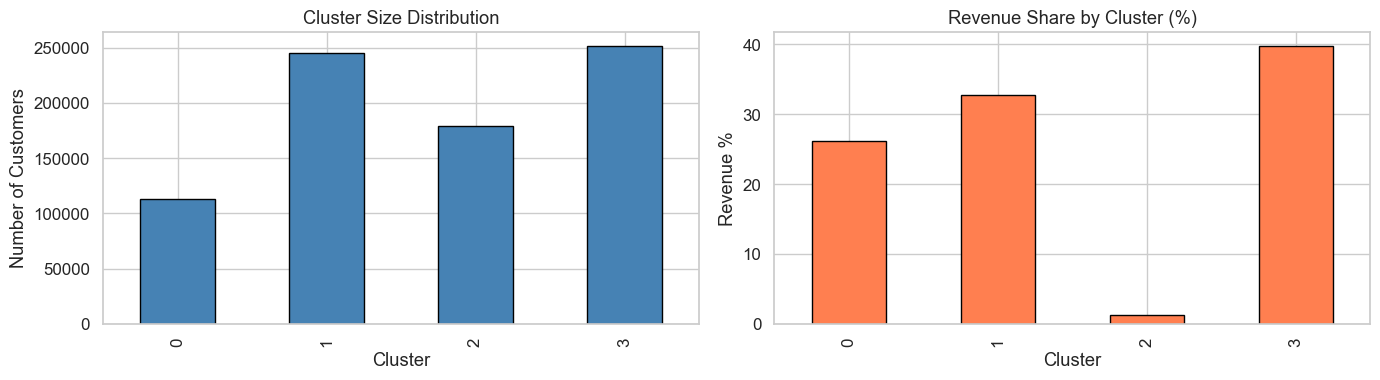

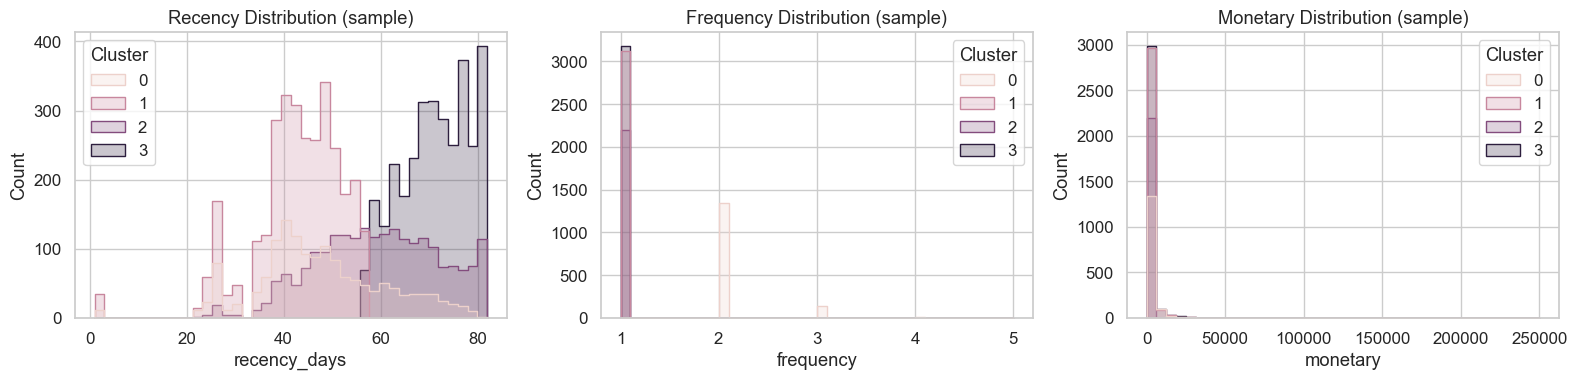

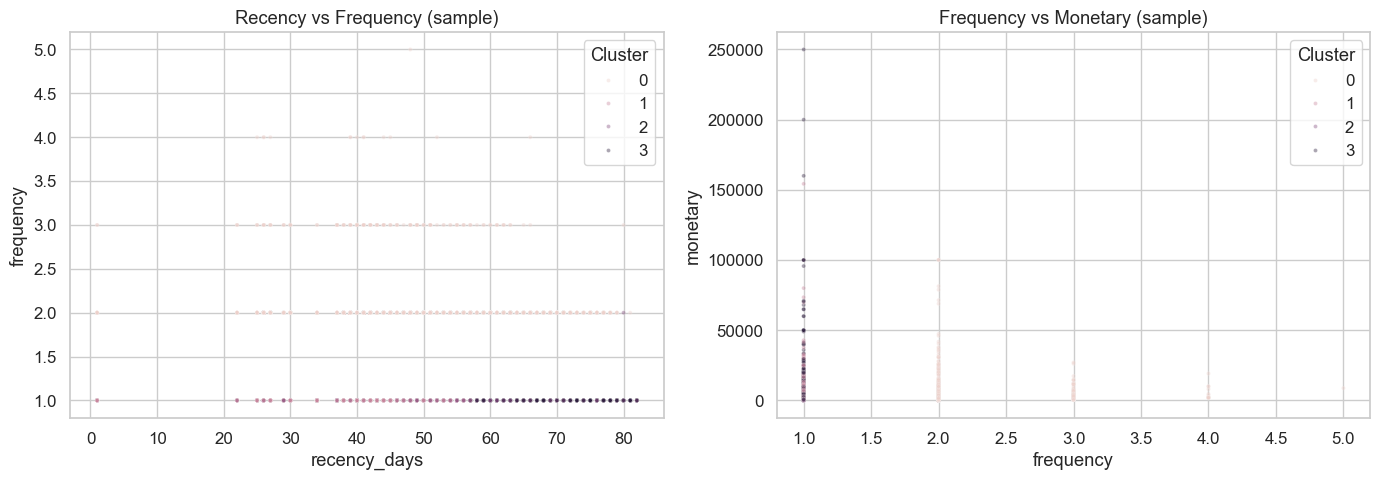

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Take a sample for faster plotting in dense data
sample = rfm.sample(n=min(10000, len(rfm)), random_state=42)

# ==========================================================
# 1) Cluster sizes and revenue share
# ==========================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Cluster size plot
rfm['Cluster'].value_counts().sort_index().plot(
    kind='bar', ax=axes[0], color='steelblue', edgecolor='black'
)
axes[0].set_title("Cluster Size Distribution")
axes[0].set_xlabel("Cluster")
axes[0].set_ylabel("Number of Customers")

# Revenue share plot
(rfm.groupby('Cluster')['monetary'].sum() / rfm['monetary'].sum() * 100) \
    .sort_index().plot(
        kind='bar', ax=axes[1], color='coral', edgecolor='black'
)
axes[1].set_title("Revenue Share by Cluster (%)")
axes[1].set_xlabel("Cluster")
axes[1].set_ylabel("Revenue %")

plt.tight_layout()
plt.show()


# ==========================================================
# 2) R, F, M Distributions per cluster (using sample)
# ==========================================================
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

sns.histplot(sample, x='recency_days', hue='Cluster', bins=40, ax=axes[0], stat='count', element='step')
axes[0].set_title("Recency Distribution (sample)")

sns.histplot(sample, x='frequency', hue='Cluster', bins=40, ax=axes[1], stat='count', element='step')
axes[1].set_title("Frequency Distribution (sample)")

sns.histplot(sample, x='monetary', hue='Cluster', bins=40, ax=axes[2], stat='count', element='step')
axes[2].set_title("Monetary Distribution (sample)")

plt.tight_layout()
plt.show()


# ==========================================================
# 3) 2D Structure Plots (sample scatter)
# ==========================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.scatterplot(data=sample, x='recency_days', y='frequency', hue='Cluster', s=8, alpha=0.4, ax=axes[0])
axes[0].set_title("Recency vs Frequency (sample)")

sns.scatterplot(data=sample, x='frequency', y='monetary', hue='Cluster', s=8, alpha=0.4, ax=axes[1])
axes[1].set_title("Frequency vs Monetary (sample)")

plt.tight_layout()
plt.show()


#### Cluster Computations

In [42]:
# ---------- GLOBAL THRESHOLDS ----------
rec_p30 = np.percentile(rfm['recency_days'], 30)
mon_p90 = np.percentile(rfm['monetary'], 90)
mon_p70 = np.percentile(rfm['monetary'], 70)

# ---------- TOP 1% REVENUE SHARE ----------
def top1_rev_share(x):
    n = max(1, int(0.01 * len(x)))
    total = x['monetary'].sum()
    return (x['monetary'].nlargest(n).sum() / total * 100) if total > 0 else 0

# ---------- GROUP ----------
g = rfm.groupby('Cluster')

# ---------- METRICS (same structure as screenshot) ----------
metrics = pd.DataFrame({
    'Customers'         : g.size(),
    'Revenue_Sum'       : g['monetary'].sum(),
    'Revenue_%'         : g['monetary'].sum().pipe(lambda s: s/s.sum()*100),
    'Recency_Median'    : g['recency_days'].median(),
    'Frequency_Median'  : g['frequency'].median(),
    'Monetary_Median'   : g['monetary'].median(),
    'Recent_%(<=p30)'   : g.apply(lambda x: (x['recency_days'] <= rec_p30).mean()*100),
    'HighSpend90_%(>=p90)': g.apply(lambda x: (x['monetary'] >= mon_p90).mean()*100),
    'MidHigh70_90_%'    : g.apply(lambda x: ((x['monetary'] >= mon_p70) & (x['monetary'] < mon_p90)).mean()*100),
    'Repeaters_%(freq>=2)': g.apply(lambda x: (x['frequency'] >= 2).mean()*100),
    'Top1%_RevShare_%'  : g.apply(top1_rev_share)
}).round(2)

# ---------- PRINT ----------
print(metrics.sort_values('Revenue_Sum', ascending=False).to_string())


C:\Users\icons\AppData\Local\Temp\ipykernel_14308\1126348264.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'Recent_%(<=p30)'   : g.apply(lambda x: (x['recency_days'] <= rec_p30).mean()*100),
C:\Users\icons\AppData\Local\Temp\ipykernel_14308\1126348264.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'HighSpend90_%(>=p90)': g.apply(lambda x: (x['monetary'] >= mon_p90).mean()*100),
C:\Users\icons\A

         Customers   Revenue_Sum  Revenue_%  Recency_Median  Frequency_Median  Monetary_Median  Recent_%(<=p30)  HighSpend90_%(>=p90)  MidHigh70_90_%  Repeaters_%(freq>=2)  Top1%_RevShare_%
Cluster                                                                                                                                                                                      
3           251695  5.927605e+08      39.81            71.0               1.0           859.77             0.00                 11.92           25.04                  0.00             24.97
1           244806  4.885033e+08      32.81            44.0               1.0           700.00            64.95                 10.11           22.36                  0.00             25.20
0           113116  3.895979e+08      26.16            47.0               2.0          1485.00            50.64                 21.35           35.36                100.00             20.25
2           179081  1.821112e+07       1.22       

C:\Users\icons\AppData\Local\Temp\ipykernel_14308\1126348264.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'Top1%_RevShare_%'  : g.apply(top1_rev_share)


#### --- Assign segment names based on interpretation ---

In [43]:
cluster_to_segment = {
    1: "Active High Value",
    0: "Loyal Frequent Buyers",
    3: "Big Spenders - At Risk",
    2: "Low Value / One-time"
}

rfm["Segment_Name"] = rfm["Cluster"].map(cluster_to_segment)


In [44]:
biz = (
    rfm.groupby("Segment_Name")
    .agg(
        Customers=('CustomerID', 'count'),
        Avg_Recency=('recency_days', 'mean'),
        Avg_Frequency=('frequency', 'mean'),
        Avg_Monetary=('monetary', 'mean'),
        Total_Revenue=('monetary', 'sum')
    )
    .round(2)
)

biz['Revenue_%'] = (biz['Total_Revenue'] / biz['Total_Revenue'].sum() * 100).round(1)

# Sort by total revenue contribution
biz_sorted = biz.sort_values('Total_Revenue', ascending=False)
print(biz_sorted.to_string())


                        Customers  Avg_Recency  Avg_Frequency  Avg_Monetary  Total_Revenue  Revenue_%
Segment_Name                                                                                         
Big Spenders - At Risk     251695        70.87           1.00       2355.07   5.927605e+08       39.8
Active High Value          244806        42.98           1.00       1995.47   4.885033e+08       32.8
Loyal Frequent Buyers      113116        48.44           2.13       3444.23   3.895979e+08       26.2
Low Value / One-time       179081        59.02           1.00        101.69   1.821112e+07        1.2


#### RFM Segmanetation Table

In [45]:
# function to apply qcut
def safe_qcut(series, q=5, labels=None):
    # If all values are identical, assign middle score (to avoid qcut error)
    if series.nunique() == 1:
        return pd.Series([3] * len(series), index=series.index)
    else:
        return pd.qcut(series.rank(method="first"), q=q, labels=labels)


In [48]:
# Quantile-based Scoring ---
rfm["R_Score"] = safe_qcut(rfm["recency_days"], q=5, labels=[5, 4, 3, 2, 1])  # lower Recency = better
rfm["F_Score"] = safe_qcut(rfm["frequency"], q=5, labels=[1, 2, 3, 4, 5])     # higher better
rfm["M_Score"] = safe_qcut(rfm["monetary"], q=5, labels=[1, 2, 3, 4, 5])      # higher better

# Convert to int and calculate total score
rfm[["R_Score","F_Score","M_Score"]] = rfm[["R_Score","F_Score","M_Score"]].astype(int)
rfm["RFM_Score"] = rfm[["R_Score", "F_Score", "M_Score"]].sum(axis=1)

# Build final RFM segmentation table 
rfm_seg_table = rfm[['CustomerID', 'recency_days', 'frequency', 'monetary',
                     'R_Score', 'F_Score', 'M_Score', 'RFM_Score',
                     'Cluster', 'Segment_Name']]

display(rfm_seg_table.head(10))
print(f"\nTotal customers in RFM table: {len(rfm_seg_table):,}")


,CustomerID,recency_days,frequency,monetary,R_Score,F_Score,M_Score,RFM_Score,Cluster,Segment_Name
0,C1010011,26,1,4750.0,5,1,5,11,1,Active High Value
1,C1010012,69,1,1499.0,2,1,4,7,3,Big Spenders - At Risk
2,C1010014,76,2,1455.0,1,5,4,10,0,Loyal Frequent Buyers
3,C1010018,37,1,30.0,5,1,1,7,2,Low Value / One-time
4,C1010024,65,1,5000.0,2,1,5,8,3,Big Spenders - At Risk
5,C1010031,79,2,1864.0,1,5,4,10,0,Loyal Frequent Buyers
6,C1010035,56,2,750.0,3,5,3,11,0,Loyal Frequent Buyers
7,C1010037,74,1,19680.0,1,1,5,7,3,Big Spenders - At Risk
8,C1010038,45,1,100.0,4,1,1,6,2,Low Value / One-time
9,C1010039,50,1,915.0,4,1,4,9,1,Active High Value



Total customers in RFM table: 788,698


#### Saving the RRM Segmentation Table

In [53]:
rfm_seg_table.to_csv("../data/rfm_segmentation_table.csv", index=False)
print("✅ File saved as: rfm_segmentation_table.csv")

✅ File saved as: rfm_segmentation_table.csv


#### Printing KMeans Customer Segment Table

In [50]:
# Select only the required columns
kmeans_segment_table = rfm[['CustomerID', 'recency_days', 'frequency', 'monetary',
                            'Cluster', 'Segment_Name']]

# Print table with a title
print("\n===== KMeans Customer Segment Table =====\n")
display(kmeans_segment_table.head(20))

print(f"\nTotal rows: {len(kmeans_segment_table):,}")


===== KMeans Customer Segment Table =====



,CustomerID,recency_days,frequency,monetary,Cluster,Segment_Name
0,C1010011,26,1,4750.00,1,Active High Value
1,C1010012,69,1,1499.00,3,Big Spenders - At Risk
2,C1010014,76,2,1455.00,0,Loyal Frequent Buyers
3,C1010018,37,1,30.00,2,Low Value / One-time
4,C1010024,65,1,5000.00,3,Big Spenders - At Risk
5,C1010031,79,2,1864.00,0,Loyal Frequent Buyers
6,C1010035,56,2,750.00,0,Loyal Frequent Buyers
7,C1010037,74,1,19680.00,3,Big Spenders - At Risk
8,C1010038,45,1,100.00,2,Low Value / One-time
9,C1010039,50,1,915.00,1,Active High Value



Total rows: 788,698


#### Saving the KMeans Customer Segment Table

In [52]:
kmeans_segment_table.to_csv("../data/KMeans_Customer_Segment_Table.csv", index=False)

print("✅ File saved as: KMeans_Customer_Segment_Table.csv")


✅ File saved as: KMeans_Customer_Segment_Table.csv
